In [1]:
#Uncomment this if you want to install the packages
!pip install jax
!pip install distrax
!pip install tensorflow
!pip install tensorflow-probability
# !pip install numpyro
!pip install optax
# !pip uninstall -y blackjax
!pip install git+https://github.com/Habush/blackjax.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201903 sha256=242a2f1ce2051c19a769fcd2995f751c8f1e3c0b4cd10ed03639d0912825fb78
  Stored in directory: /root/.cache/pip/wheels/59/9d/cb/21506ed546ffa6e339e75a0bb7500d363d68349a89f9c5a080
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import distrax
import blackjax
import seaborn as sns
import optax

from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
%load_ext autoreload


In [3]:
plt.style.use('ggplot')

In [4]:
def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

In [5]:
jax.default_backend()

'cpu'

In [6]:
rng_key = jax_prng_key()

In [7]:
loc, scale = 2, 10
np.random.seed(42)
observed = np.random.normal(loc, scale, size=1000)

from functools import partial
def logprob_fn(loc, scale, observed=observed):
  """Univarate normal"""
  logpdf = stats.norm.logpdf(observed, loc, scale)
  return jnp.sum(logpdf)


logprob = lambda x: logprob_fn(**x)

In [8]:
## Inference loop implemented using lax.scan
def inference_loop(rng_key, kernel, initial_state, num_samples):
  @jax.jit
  def one_step(state, rng_key):
    state, _ = kernel(rng_key, state)
    return state, state

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states



def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
  
  def one_step(states, rng_key):
    keys = jax.random.split(rng_key, num_chains)
    states, _ = jax.vmap(kernel)(keys, states)
    return states, states

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states 

### Sample multiple chains
We can easily sample multiple chains using JAX’s vmap construct. See the documentation to understand how the mapping works.

### MALA

In [ ]:
rng_key = jax.random.PRNGKey(0)
mala = blackjax.mala(logprob, 1e-3)
initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = mala.init(initial_position)
mala_kernel = jax.jit(mala.step)
states = inference_loop(rng_key, mala_kernel, initial_state, 1_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

In [ ]:
def inference_loop_mala(rng_key, kernel, initial_state, num_samples):
  @jax.jit
  def one_step(state, rng_key):
    state, _ = kernel(rng_key, state)
    return state, state

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states

In [ ]:
def diff_step_sizes(initial_position, step_sizes):
  @jax.jit
  def body_func(i, step_size):
    mala = blackjax.mala(logprob, step_size)
    initial_position = {"loc": 1.0, "scale": 2.0}
    initial_state = mala.init(initial_position)
    mala_kernel = jax.jit(mala.step)
    states = inference_loop(rng_key, mala_kernel, initial_state, 10_000)
    loc_mean = jnp.mean(states.position["loc"])
    scale_mean = jnp.mean(states.position["scale"])

    return i+1, jnp.array([loc_mean, scale_mean])


  _, arr = jax.lax.scan(body_func, 0, step_sizes)

  return arr

In [ ]:
step_sizes = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
step_size_arr = diff_step_sizes(initial_position, step_sizes)

In [ ]:
step_size_arr.shape

(6, 2)

Text(0, 0.5, 'scale')

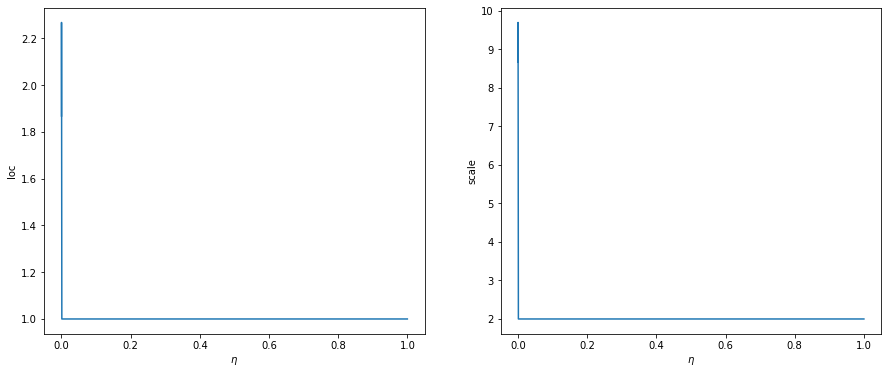

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(step_sizes, step_size_arr[:,0])
ax.set_xlabel("$\eta$")
ax.set_ylabel("loc")

ax1.plot(step_sizes, step_size_arr[:,1])
ax1.set_xlabel("$\eta$")
ax1.set_ylabel("scale")

/home/xabush/miniconda3/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/xabush/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


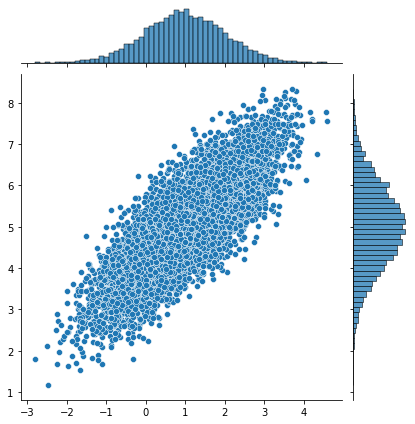

In [ ]:
mus = np.array([1, 5])
sigmas = np.array([[1, .8], [.8, 1]])


mvn = distrax.MultivariateNormalFullCovariance(loc=mus, covariance_matrix=sigmas)
samples = mvn.sample(seed=rng_key, sample_shape=(10000,))
sns.jointplot(samples[:,0], samples[:,1])

In [ ]:
from torch.utils import data

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)


In [7]:
# generate batches
def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        yield data[idx]

In [8]:
# For reproducibility
rng = np.random.RandomState(seed=45)

# Precision
dtype = jnp.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]
                + rng.randn(num_samples, dims).astype(dtype))

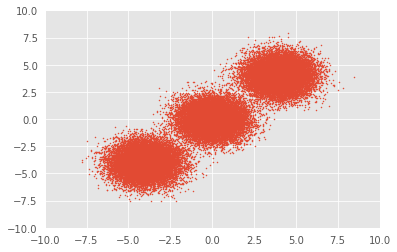

In [9]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

In [10]:
# Upperbound on K
max_cluster_num = 30

mix_probs = jnp.ones([max_cluster_num]) / max_cluster_num

loc = jax.random.uniform(rng_key, minval=-9, maxval=9, shape=(max_cluster_num, dims))
precision = jnp.ones((max_cluster_num, dims))
alpha = jnp.ones([1])

init_pos = {"mix_probs": mix_probs, "loc": loc, "precision": precision, "alpha": alpha}
# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
joint_dist = tfd.JointDistributionNamed(dict(
    alpha = tfd.InverseGamma(
        concentration=jnp.ones([1]),
        scale=jnp.ones([1]),
        name='alpha'),

    mix_probs = lambda alpha: tfd.Dirichlet(
        concentration=jnp.ones(max_cluster_num) * alpha / max_cluster_num,
        name='mix_probs'),

    loc = tfd.Independent(
        tfd.Normal(
            loc=jnp.zeros([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='loc'),


    precision = tfd.Independent(
        tfd.InverseGamma(
            concentration=jnp.ones([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='precision')
))

In [18]:
print(joint_dist)

tfp.distributions.JointDistributionNamed("JointDistributionNamed", batch_shape={alpha: [1], loc: [30], mix_probs: [], precision: [30]}, event_shape={alpha: [], loc: [2], mix_probs: [30], precision: [2]}, dtype={alpha: float32, loc: float32, mix_probs: float32, precision: float32})


In [17]:

data_size = observations.shape[0]
# batch_size = int(0.1*data_size)
batch_size = 20
batches = batch_data(rng_key, observations, batch_size, data_size)

In [31]:
softmax_jacob_fn = lambda x: jax.jacfwd(jax.nn.softmax)(x)
softplus_jacob_fn = jax.vmap(lambda x: jax.jacfwd(jax.nn.softplus)(x))
jacob_det_fn =  jax.vmap(lambda x: jnp.linalg.det(x))


def logprior_fn(position):
    alpha = jax.nn.softplus(position["alpha"])
    precision = jax.nn.softplus(position["precision"])
    mix_probs = jax.nn.softmax(position["mix_probs"])
    # log_det_softmax_jacob = jnp.sum()
    # log_det_softplus_jacob = jnp.sum(jnp.log(softplus_jacob_fn(position["alpha"]))) + \
    #                                  jnp.sum(jnp.log(jacob_det_fn(softplus_jacob_fn(position["precision"]))))

    changed_pos = {"alpha": alpha, "precision": precision, "mix_probs": mix_probs, "loc": position["loc"]}
    joint_logp = jnp.sum(joint_dist.log_prob(changed_pos)) / num_samples

    # return joint_logp + log_det_softplus_jacob + log_det_softmax_jacob
    return joint_logp

def loglikelihood_fn(position, batch_data):
    # log_det_softmax_jacob = jnp.sum(jnp.log(softmax_jacob_fn(position["mix_probs"])))
    # log_det_softplus_jacob = jnp.sum(jnp.log(jacob_det_fn(softplus_jacob_fn(position["precision"]))))
    _, loc, mix_probs, precision = jax.tree_util.tree_flatten(position)[0]
    precision = jax.nn.softplus(precision)
    mix_probs = jax.nn.softmax(mix_probs)
    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=mix_probs),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc,
            scale_diag=precision))
    # print(dist.log_prob(batch_data), log_det_softplus_jacob, log_det_softmax_jacob)
    # return dist.log_prob(batch_data) + log_det_softplus_jacob + log_det_softmax_jacob
    return dist.log_prob(batch_data)

In [34]:
loglikelihood_fn(init_pos ,next(batches)).shape

(20,)

In [21]:
from blackjax.sgmcmc.gradients import grad_estimator
init_step_size = 1e-6
end_step_size = 1e-10
num_warmup = 1000
num_samples = 10000
schedule_fn = optax.exponential_decay(init_step_size, num_samples, 0.99)
# schedule_fn = optax.polynomial_schedule(init_step_size, end_step_size, 1, num_samples)
# schedule_fn = lambda _ : init_step_size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn, schedule_fn)

state = sgld.init(init_pos, next(batches))
step_fn = jax.jit(sgld.step)

post_samples = []
acc_info = []
for step in range(num_warmup + num_samples):
  _, rng_key = jax.random.split(rng_key)
  batch = next(batches)
  state = step_fn(rng_key, state, batch)
  if step % 1000 == 0:
    print("=", end="")

  if step > num_warmup:
    post_samples.append(state.position)

In [22]:
sample_size = 100

mix_probs_posterior, alpha_posterior = [], []
loc_posterior, precision_posterior = [], []
for position in post_samples:
  mix_probs_posterior.append(position["mix_probs"])
  alpha_posterior.append(position["alpha"])
  loc_posterior.append(position["loc"])
  precision_posterior.append(position["precision"])


mix_probs_posterior, alpha_posterior = jax.nn.softmax(jnp.array(mix_probs_posterior)[num_warmup:]), \
                                       jax.nn.softplus(jnp.array(alpha_posterior)[num_warmup:])
loc_posterior, precision_posterior = jnp.array(loc_posterior)[num_warmup:], \
                                     jax.nn.softplus(jnp.array(precision_posterior)[num_warmup:])
mean_mix_probs_ = jnp.mean(mix_probs_posterior[-sample_size:], axis=0)
mean_alpha_ = jnp.mean(alpha_posterior[-sample_size:], axis=0)
mean_loc_ = jnp.mean(loc_posterior[-sample_size:], axis=0)
mean_precision_ = jnp.mean(precision_posterior[-sample_size:], axis=0)

Value of inferred alpha = 1.390



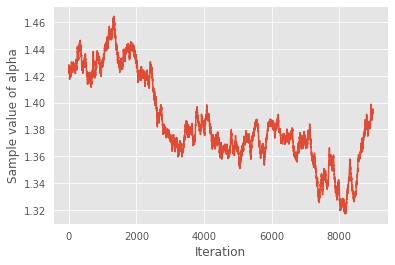

In [23]:
print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))

plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(alpha_posterior)
plt.show()


In [24]:
mean_mix_probs_

DeviceArray([1.1714430e-03, 2.8647936e-04, 2.6483036e-04, 2.6114244e-04,
             2.8156160e-04, 2.2912830e-04, 2.9067791e-04, 2.4471190e-04,
             8.4313430e-04, 2.4116779e-04, 2.6866439e-04, 8.2837860e-04,
             4.7514154e-04, 3.7794939e-04, 3.6426753e-04, 2.7604870e-04,
             2.5945200e-04, 2.4488388e-04, 4.1388720e-04, 2.3736543e-04,
             2.7521205e-04, 3.2254049e-01, 3.4475600e-04, 3.9750544e-04,
             3.2547617e-01, 5.0012581e-04, 2.5563536e-04, 2.7195920e-04,
             2.5580308e-04, 3.4182194e-01], dtype=float32)

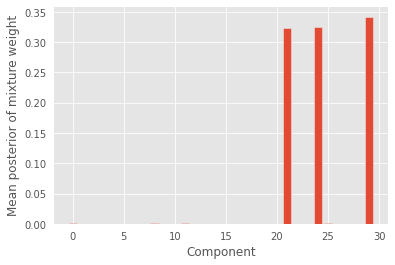

In [25]:
plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

In [26]:
def get_cluster_assignment(probs, loc, scale):
  component_dist = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
  unnormalized_posterior = component_dist.log_prob(jnp.expand_dims(jnp.expand_dims(observations, axis=1), axis=1)) + jnp.log(probs[None,...])
  print(unnormalized_posterior.shape)
  posterior = unnormalized_posterior - jax.nn.logsumexp(unnormalized_posterior, axis=-1)[...,None]
  posterior = jnp.mean(posterior, axis=1)
  cluster = jnp.argmax(posterior, axis=1)
  return cluster

In [27]:
cluster_assigment = get_cluster_assignment(mix_probs_posterior[-sample_size:], loc_posterior[-sample_size:],
                                           precision_posterior[-sample_size:])
idxs, count = jnp.unique(cluster_assigment, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))

(50000, 100, 30)
Number of inferred clusters = 8



In [28]:
def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

In [29]:
cluster_cmap = convert_int_elements_to_consecutive_numbers_in(np.array(cluster_assigment))

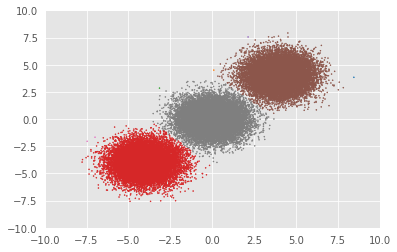

In [30]:
cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(cluster_cmap))
plt.axis([-10, 10, -10, 10])
plt.show()